# Numerical Differentation

For optimization problems we often need to obtain the gradient of a function. Often it is not easy or possible to do this analytically. Therefor we use numerical methods. 

In python there are several modules that facilitate differentation:

* [algopy](https://pythonhosted.org/algopy/)
* [Autograd](https://github.com/HIPS/autograd) / [Jax](https://jax.readthedocs.io/en/latest/index.html)
* [PyTorch](https://pytorch.org/docs/stable/autograd.html)

Let's try it with the simple function $f(x) = x^2$

In [1]:
def f(x):
    return x**2

## Algopy

In [2]:
import algopy as al

In [3]:
help(al.UTPM.init_jacobian)

Help on method init_jacobian in module algopy.utpm.utpm:

init_jacobian(x, dtype=None) method of builtins.type instance
    initializes this UTPM instance to compute the Jacobian,
    
    it is possible to force the dtype to a certain dtype,
    if no dtype is provided, the dtype is inferred from x



In [4]:
j = al.UTPM.init_jacobian([1,2,3])
j

UTPM([[[1. 2. 3.]
  [1. 2. 3.]
  [1. 2. 3.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]])

In [5]:
 al.UTPM.extract_jacobian(j)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [6]:
fj = f(j)
fj

UTPM([[[1. 4. 9.]
  [1. 4. 9.]
  [1. 4. 9.]]

 [[2. 0. 0.]
  [0. 4. 0.]
  [0. 0. 6.]]])

In [7]:
 al.UTPM.extract_jacobian(fj)

array([[2., 0., 0.],
       [0., 4., 0.],
       [0., 0., 6.]])

## JAX

In [8]:
import jax
import numpy as np

In [9]:
df = jax.jacfwd(f)
df(np.array([1.,2.,3.]))

DeviceArray([[2., 0., 0.],
             [0., 4., 0.],
             [0., 0., 6.]], dtype=float32)

In [10]:
df = jax.jacrev(f)
df(np.array([1.,2.,3.]))

DeviceArray([[2., 0., 0.],
             [0., 4., 0.],
             [0., 0., 6.]], dtype=float32)

In [11]:
df2 = jax.vmap(jax.grad(f))
df2(np.array([1.,2.,3.]))

DeviceArray([2., 4., 6.], dtype=float32)

# Filters

In [12]:
from scipy import signal
from dsp import simplify_biquad_filters
import dsp
sos = signal.iirfilter(2, 100, btype='low',
                       analog=False, rs=60,
                        ftype='cheby2', fs=1000,output='sos')
print("{} filter sections: \n".format(len(sos)), sos)

1 filter sections: 
 [[ 1.18652453e-03 -1.54563590e-03  1.18652453e-03  1.00000000e+00
  -1.95892877e+00  9.59756186e-01]]


In [13]:
c = simplify_biquad_filters(sos)

In [14]:
df = jax.jacfwd(dsp.group_delay)

## Group Delay

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['axes.grid'] = True
                                  

import jax.numpy as jnp

def group_delay(c, w):
    """
    Calculates the group delay for filter with coefficients c for the given frequencies in w
    
    Parameters
    ----------
    
    c: ndarray
        list of all coefficients of all seconds order stages:
        [a_01 a_11 b_01 b_11 ... b_0N b_1N H0]

    w: ndarray
        frequency bins in the range [0, π] to evaluate the group delay on

    """
    
    J = len(c) // 4 # num stages: we don't use H0 = c[-1]
    group_delay = 0
    for i in range(0, J*4, 4):

        a0, a1, b0, b1 = c[i:i+4]

        alpha_n = 1 - a0**2 + a1*(1 - a0) * jnp.cos(w)
        beta_n = a0**2 + a1**2 + 1 + 2*a0*1*(2*jnp.cos(w)**2 - 1) + 2*a1*(a0 + 1)*jnp.cos(w)
        alpha_d = 1 - b0**2 + b1*(1 - b0)*jnp.cos(w)
        beta_d =  b0**2 + b1**2 + 1 + 2*b0*1*(2*jnp.cos(w)**2 - 1) + 2*b1*(b0 + 1)*jnp.cos(w)

        group_delay += -alpha_n/beta_n + alpha_d/beta_d

    return group_delay

In [16]:
c

array([ 1.00000000e+00, -1.30265819e+00,  9.59756186e-01, -1.95892877e+00,
        1.18652453e-03])

In [17]:
w = np.linspace(0.1, np.pi, 12, dtype='float32') # jnp uses float32 by default. For w=0 there is a different between float32 and float64
group_delay(c, w)

DeviceArray([4.434561  , 0.294925  , 0.10001332, 0.05116341, 0.03194387,
             0.02253046, 0.01730407, 0.01418378, 0.01226121, 0.01109693,
             0.01046859, 0.01026972], dtype=float32)

In [18]:
dsp.group_delay(c, w)

array([4.434561  , 0.294925  , 0.10001332, 0.05116337, 0.03194387,
       0.02253046, 0.01730407, 0.01418378, 0.01226121, 0.01109693,
       0.01046859, 0.01026972], dtype=float32)

In [19]:
group_delay_gradient = jax.jacrev(group_delay)

In [20]:
w = np.linspace(0.1, np.pi, 10, dtype='float32') # jnp uses float32 by default. For w=0 there is a different between float32 and float64
gd = group_delay(c, w)
gd_g = group_delay_gradient(c, w)

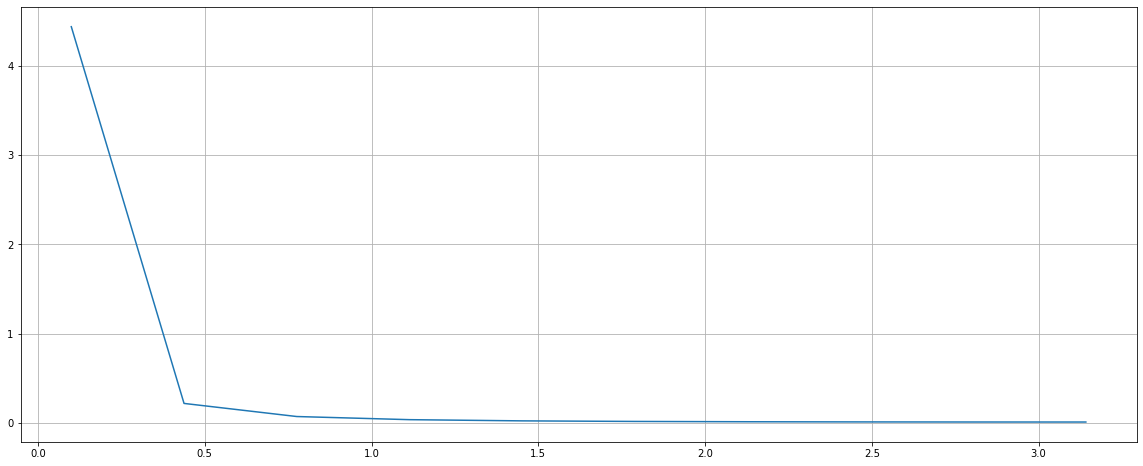

In [21]:
plt.plot(w, gd)

In [22]:
gd.shape

(10,)

In [23]:
gd_g.shape

(10, 5)

# Magnitude Squared

In [24]:

def H_eval(c, w):
    """ Evaluates the filter transfer function for each frequency in w.

    Parameters
    ----------
     c: ndarray
        list of all coefficients of all seconds order stages:
        [a_01 a_11 b_01 b_11 ... b_0N b_1N H0]
            
    w : ndarray
        frequency bins between 0 and 2π
        
    Returns
    -------
    
    H: ndarray with dtype 'complex64'
    
    """

    _H = jnp.ones(len(w), dtype='complex64')
    J = len(c) // 4 # number of 2nd order filter sections
    H0 = c[J*4] # H0 is the first element after the coefficients. 
    for i in range(0, J*4, 4):
        a0, a1, b0, b1 = c[i:i+4]
        _H *= (a0 + a1*jnp.exp(1j*w) + jnp.exp(2*1j*w)) / (b0 + b1*jnp.exp(1j*w) + jnp.exp(2*1j*w))
    return H0 * _H

def H_mag_squared(c, w):
    """ 
    Calculcate the squared magnitude response of the filter.
    
    Parameters
    ----------
     c: ndarray
        list of all coefficients of all seconds order stages:
        [a_01 a_11 b_01 b_11 ... b_0N b_1N H0]
            
    w : ndarray
        frequency bins between 0 and 2π
        
        
    Returns
    -------
    
    H: ndarray with dtype 'float32'
        
    """
    return jnp.abs(H_eval(c,w))**2

In [25]:
H_mag_squared_gradient = jax.jacrev(H_mag_squared)

In [26]:
H_eval(c, w)

DeviceArray([-0.07576647-3.3961475e-02j, -0.00324933-3.0117389e-04j,
             -0.00026395-1.3282791e-05j,  0.00045519+1.5022849e-05j,
              0.00073178+1.6938713e-05j,  0.0008641 +1.4234483e-05j,
              0.00093482+1.0663560e-05j,  0.0009739 +7.0300780e-06j,
              0.00099385+3.4826121e-06j,  0.001     -8.9779920e-13j],            dtype=complex64)

In [27]:
H_mag_squared_gradient(c, w).T

DeviceArray([[ 1.99592561e-02,  3.79241355e-05,  7.98256508e-07,
              -4.35512305e-07, -1.19401292e-07,  1.86796797e-07,
               3.91542130e-07,  5.16937746e-07,  5.84333861e-07,
               6.05572723e-07],
             [ 2.00594701e-02,  4.18763921e-05,  1.11834368e-06,
              -9.87115300e-07, -1.00593445e-06, -8.59897284e-07,
              -7.40737107e-07, -6.62623279e-07, -6.19368564e-07,
              -6.05572723e-07],
             [ 1.33183432e+00,  1.08363936e-04,  1.86346085e-07,
               1.78293206e-07,  8.78992239e-08, -1.25967347e-07,
              -3.02831467e-07, -4.21845158e-07, -4.88842829e-07,
              -5.10375173e-07],
             [ 1.28091371e+00,  1.14679475e-04,  2.48783522e-07,
               3.78690942e-07,  6.20404876e-07,  6.26230701e-07,
               5.83601320e-07,  5.43879594e-07,  5.18791126e-07,
               5.10375173e-07],
             [ 1.16203928e+01,  1.79496035e-02,  1.17732838e-04,
               3.49633861e-

In [28]:
import gradients

In [29]:
tau = np.mean(gradients._group_delay(c, w))

In [30]:
x = np.r_[c, tau]

In [31]:
gdd_grad = gradients.group_delay_deviation_gradient(x, w)

In [32]:
gdd_grad.shape

(10, 6)

In [33]:
gdd_grad[0]

DeviceArray([ 1.4897845e+00,  0.0000000e+00,  1.1657266e+03,
              1.2410339e+03,  0.0000000e+00, -1.0000000e+00],            dtype=float32)

In [34]:
gradients._group_delay(c, w).shape

(10,)

In [35]:
gdd_grad[:, 0]

DeviceArray([ 1.4897845 ,  3.1713195 , 68.58904   ,  8.069616  ,
              1.6261872 ,  0.7565568 ,  0.48279208,  0.36799756,
              0.31740344,  0.3027864 ], dtype=float32)

In [36]:
gdd_grad

DeviceArray([[ 1.4897845e+00,  0.0000000e+00,  1.1657266e+03,
               1.2410339e+03,  0.0000000e+00, -1.0000000e+00],
             [ 3.1713195e+00,  0.0000000e+00, -2.0298386e+00,
               3.4194522e+00,  0.0000000e+00, -1.0000000e+00],
             [ 6.8589043e+01,  0.0000000e+00, -1.4657755e+00,
               3.4726948e-01,  0.0000000e+00, -1.0000000e+00],
             [ 8.0696163e+00,  0.0000000e+00, -8.4865284e-01,
               8.1952862e-02,  0.0000000e+00, -1.0000000e+00],
             [ 1.6261872e+00,  0.0000000e+00, -5.6194872e-01,
               2.8595442e-02,  0.0000000e+00, -1.0000000e+00],
             [ 7.5655681e-01,  0.0000000e+00, -4.1512015e-01,
               1.2613251e-02,  0.0000000e+00, -1.0000000e+00],
             [ 4.8279208e-01,  0.0000000e+00, -3.3407891e-01,
               6.6013816e-03,  0.0000000e+00, -1.0000000e+00],
             [ 3.6799756e-01,  0.0000000e+00, -2.8853643e-01,
               4.0353509e-03,  0.0000000e+00, -1.0000000e+00],


In [37]:
gradients._group_delay(c, w)

DeviceArray([4.434561  , 0.21855392, 0.0718529 , 0.03677619, 0.02331203,
             0.0168762 , 0.01343778, 0.01153842, 0.0105687 , 0.01026972],            dtype=float32)

# Complex frequency response

In [64]:
primals_out, vjpfun = jax.vjp(H_eval, c, w)

In [65]:
primals_out

DeviceArray([ 1.0000495e+00-3.76516953e-04j,
              6.8833703e-01-6.78954840e-01j,
             -8.0356182e-04-4.83440635e-05j,
              5.1608123e-04+1.60509262e-05j,
             -3.9193537e-02+1.18483035e-02j], dtype=complex64)

In [66]:
vjpfun(c)

TypeError: Type of cotangent input to vjp pullback function (complex64) is not the expected tangent type (float32) of corresponding primal output with dtype float32.

In [67]:
c

array([ 1.00000000e+00, -1.30265819e+00,  9.59756186e-01, -1.95892877e+00,
        1.18652453e-03])

In [47]:
c

array([ 1.00000000e+00, -1.30265819e+00,  9.59756186e-01, -1.95892877e+00,
        1.18652453e-03])

In [52]:
c.dtype = 'complex64'

In [53]:
c

array([            nan+1.8749999j ,  1.28489454e-20-1.9128323j ,
       -9.52686300e-23+1.864939j  , -1.37341889e-08-1.994866j  ,
        4.45570985e-37+0.82593757j], dtype=complex64)

In [38]:
def H_gradient(x, w):
    
    J = len(c) // 4 # number of 2nd order filter sections
    H0 = c[J*4] # H0 is the first element after the coefficients. 
    
    H = H_eval(x, w)
    grad = []
    for i in range(0, J*4, 4):
        a0, a1, b0, b1 = c[i:i+4]
        
        
        dhda0 = (1 / (a0 + (a1 + 1) * np.exp(1j*w))) * H
        dhda1 = (np.exp(1j*w) / (a0 + (a1 + 1) * np.exp(1j*w))) * H
        
        dhdb0 = (1 / (b0 + (b1 + 1) * np.exp(1j*w))) * H
        dhdb1 = (np.exp(1j*w) / (b0 + (b1 + 1) * np.exp(1j*w))) * H
        
        
        grad.extend([dhda0, dhda1, dhdb0, dhdb1 ])

    dhdh0 = np.ones(len(w))
    dhdtau = np.zeros(len(w))
    grad.extend([dhdh0, dhdtau])

    return np.c_[grad].T
        

In [62]:
x

array([ 1.00000000e+00, -1.30265819e+00,  9.59756186e-01, -1.95892877e+00,
        1.18652453e-03,  4.84774649e-01])

In [40]:
w

array([0.1       , 0.43795475, 0.7759095 , 1.1138642 , 1.451819  ,
       1.7897737 , 2.1277285 , 2.4656832 , 2.803638  , 3.1415927 ],
      dtype=float32)

In [42]:
(len(w), len(x))

(10, 6)

In [43]:
r = H_gradient(x, w)
r.shape

(10, 6)

In [44]:
r

array([[-1.06115900e-01-5.31839542e-02j, -1.00276224e-01-6.35121688e-02j,
         3.07248116e-01-8.09465051e-01j,  3.86524856e-01-7.74747610e-01j,
         1.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [-4.26938990e-03-1.16980122e-03j, -3.37035023e-03-2.86999438e-03j,
        -1.00323034e-03-7.76476646e-03j,  2.38439883e-03-7.45739276e-03j,
         1.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [-3.09479743e-04-1.00621073e-04j, -1.50430249e-04-2.88570678e-04j,
        -1.20990866e-04-3.43423540e-04j,  1.54160633e-04-3.29868170e-04j,
         1.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 4.73390071e-04+1.65729914e-04j,  6.01306019e-05+4.97944653e-04j,
         2.24936099e-04+3.88671731e-04j, -2.49556848e-04+3.73340794e-04j,
         1.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 6.86836487e-04+2.31668426e-04j, -1.48505293e-04+7.09479267e-04j,
         3.71664617e-04+4.38354386

In [58]:
def _H_eval_al(c, w):
    """ Evaluates the filter transfer function for each frequency in w.

    Parameters
    ----------
     c: ndarray
        list of all coefficients of all seconds order stages:
        [a_01 a_11 b_01 b_11 ... b_0N b_1N H0]
            
    w : ndarray
        frequency bins between 0 and 2π
        
    Returns
    -------
    
    H: ndarray with dtype 'complex64'
    
    """
    
    _H = 1
    J = len(c) // 4    # number of 2nd order filter sections
    H0 = c[J*4]        # H0 is the first element after the coefficients. 
    print('H0', H0)
    for i in range(0, J*4, 4):
        print('stage', c[i:i+4])
        a0, a1, b0, b1 = c[i:i+4]
        _H *= (a0 + a1*al.exp(1j*w) + al.exp(2*1j*w)) / (b0 + b1*al.exp(1j*w) + al.exp(2*1j*w))
    return H0*_H
#     return H0 * _H

gradient_grid = al.UTPM.init_jacobian(x)
y = _H_eval_al(gradient_grid, w=w)
r_al = al.UTPM.extract_jacobian(y)

H0 [[0.00118652 0.00118652 0.00118652 0.00118652 0.00118652 0.00118652]
 [0.         0.         0.         0.         1.         0.        ]]
stage [[[ 1.         -1.30265819  0.95975619 -1.95892877]
  [ 1.         -1.30265819  0.95975619 -1.95892877]
  [ 1.         -1.30265819  0.95975619 -1.95892877]
  [ 1.         -1.30265819  0.95975619 -1.95892877]
  [ 1.         -1.30265819  0.95975619 -1.95892877]
  [ 1.         -1.30265819  0.95975619 -1.95892877]]

 [[ 1.          0.          0.          0.        ]
  [ 0.          1.          0.          0.        ]
  [ 0.          0.          1.          0.        ]
  [ 0.          0.          0.          1.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]]


In [57]:
r_al[0]

array([ -0.11461194 -0.03815796j,  -0.11022992 -0.04940944j,
        -6.22645954 -5.7171176j ,  -5.62459384 -6.31016465j,
       -63.85586668-28.62273865j,   0.         +0.j        ])

In [59]:
w.dtype = 'float64'

In [63]:
gradient_grid

UTPM([[[ 1.00000000e+00 -1.30265819e+00  9.59756186e-01 -1.95892877e+00
    1.18652453e-03  4.84774649e-01]
  [ 1.00000000e+00 -1.30265819e+00  9.59756186e-01 -1.95892877e+00
    1.18652453e-03  4.84774649e-01]
  [ 1.00000000e+00 -1.30265819e+00  9.59756186e-01 -1.95892877e+00
    1.18652453e-03  4.84774649e-01]
  [ 1.00000000e+00 -1.30265819e+00  9.59756186e-01 -1.95892877e+00
    1.18652453e-03  4.84774649e-01]
  [ 1.00000000e+00 -1.30265819e+00  9.59756186e-01 -1.95892877e+00
    1.18652453e-03  4.84774649e-01]
  [ 1.00000000e+00 -1.30265819e+00  9.59756186e-01 -1.95892877e+00
    1.18652453e-03  4.84774649e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00

In [52]:
r[0]

array([-0.1061159 -0.05318395j, -0.10027622-0.06351217j,
        0.30724812-0.80946505j,  0.38652486-0.77474761j,
        1.        +0.j        ,  0.        +0.j        ])

In [53]:
r_al[0]

array([ -0.11461194 -0.03815796j,  -0.11022992 -0.04940944j,
        -6.22645954 -5.7171176j ,  -5.62459384 -6.31016465j,
       -63.85586668-28.62273865j,   0.         +0.j        ])